In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import mnist

from made import MaskingDense

Using TensorFlow backend.


## Variational Autoencoder Parameters

In [2]:
img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (mg_chns, img_rows, imgi_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

batch_size = 100
latent_dim = 32
intermediate_dim = 128
epsilon_std = 1.0
epochs = 1000
activation = 'elu'
dropout = 0.0
learning_rate = 0.001
decay = 0.0
num_iaf = 4

## Load MNIST dataset

In [3]:
# Binarized MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.round(X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) / 255.)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


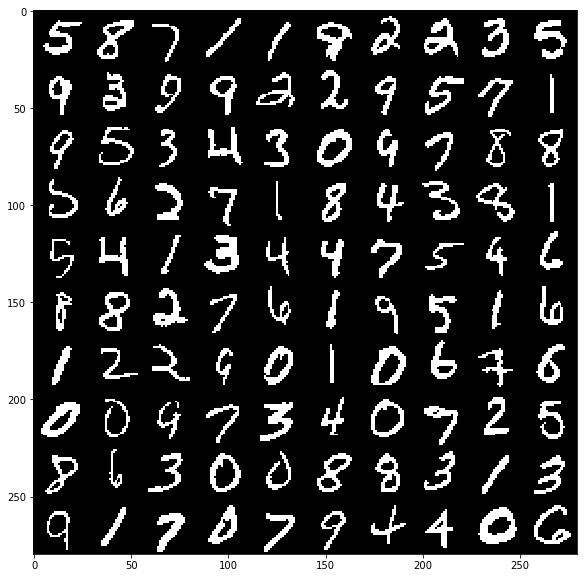

In [4]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(n, n))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    
display_digits(X_train)

# Helper Functions

In [5]:
def create_dense_layers(stage, width, activation=activation, dropout=True):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        Activation(activation),
    ]
    if dropout:
        layers.append(Dropout(dropout))
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def epsilon(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    return K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)

def combine_z_0(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    eps, z_mean, z_log_sigma = args
    return z_mean + K.exp(z_log_sigma) * eps

def combine_arnn(args):
    z_t, mean, sigma = args
    return z_t * sigma + mean * (1. - sigma)

def make_iaf_layer(prev_z, enc_h, reverse=False):
    if reverse:
        prev_z = Lambda(lambda x: K.reverse(x, axes=-1))(prev_z)
        
    iaf_in = [prev_z, enc_h] if enc_h is not None else prev_z
    m = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    s = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    sigma = Activation('sigmoid')(s)
    
    return Lambda(combine_arnn)([prev_z, m, sigma]), sigma

In [6]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_dense', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

## Loss Function

In [7]:
def logpz(x, x_decoded_mean):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

def logqz_x(x, x_decoded_mean):
    det = _z_log_sigma_0
    for z_sigma in _z_sigmas:
        det += K.log(z_sigma)
    
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)

def logpx_z(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
    return -xent_loss

def vae_loss(x, x_decoded_mean):
    # ELBO: - [logp(x|z) + logp(z) - logq(z|x)] = -logp(x|z) - logp(z) + logq(z|x)
    return K.mean(-logpx_z(x, x_decoded_mean) - logpz(x, x_decoded_mean) + logqz_x(x, x_decoded_mean), axis=-1)

# Basic VAE

In [8]:
# Encoder
enc_filters=32
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
    create_dense_layers(stage=5, width=intermediate_dim),
]
x_input = Input(batch_shape=(batch_size,) + original_img_size)
_enc_dense = inst_layers(enc_layers, x_input)

# Original z_0
e_0 = Lambda(epsilon)(_enc_dense)
_z_sigmas = []
_z_mean_0 = Dense(latent_dim)(_enc_dense)
_z_log_sigma_0 = Dense(latent_dim)(_enc_dense)
z_0 = Lambda(combine_z_0)([e_0, _z_mean_0, _z_log_sigma_0])
z = z_0

# Decoder
dec_filters = 32
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    create_dense_layers(stage=11, width=14 * 14 * 64),
    Reshape((14, 14, 64)),
    create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(14, filters=dec_filters, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=1, kernel_size=1, strides=1, activation='sigmoid'),
]
_dec_dense = inst_layers(decoder_layers, z)
_output = _dec_dense

In [9]:
vae = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
enc_conv_1 (Conv2D)              (100, 28, 28, 32)     320         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (100, 28, 28, 32)     0           enc_conv_1[0][0]                 
____________________________________________________________________________________________________
enc_conv_2 (Conv2D)              (100, 28, 28, 32)     9248        activation_1[0][0]               
___________________________________________________________________________________________

In [10]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=25)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.001 * learning_rate)

callbacks=[early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  1802.7014870643616


,loss,lr,val_loss
count,110.000000,110.000,110.000000
mean,76.504876,0.001,75.511104
std,10.388521,0.000,4.918494
min,70.925242,0.001,72.336282
0%,70.925242,0.001,72.336282
25%,72.246793,0.001,72.966600
50%,73.978120,0.001,73.711310
75%,77.251019,0.001,75.915028
95%,86.936800,0.001,83.794893
99%,99.839816,0.001,95.276416


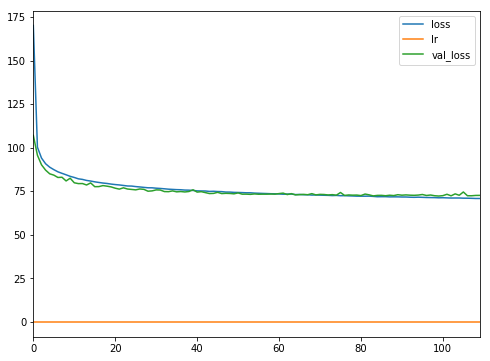

In [11]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [12]:
# Eval logpx loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpx_z)
val_logpx = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logpz loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpz)
val_logpz = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logqz_x loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logqz_x)
val_logqz_x = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

print()
print("log(p(x|z)) = %.2f" % val_logpx)
print("log(p(z)) = %.2f" % val_logpz)
print("log(q(z|x)) = %.2f" % val_logqz_x)

 8800/10000 [=========================>....] - ETA: 0s
log(p(x|z)) = 40.19
log(p(z)) = 45.70
log(q(z|x)) = 13.23


In [13]:
g_z = Input(shape=(latent_dim,))
g_output = inst_layers(decoder_layers, g_z)
generator = Model(g_z, g_output)

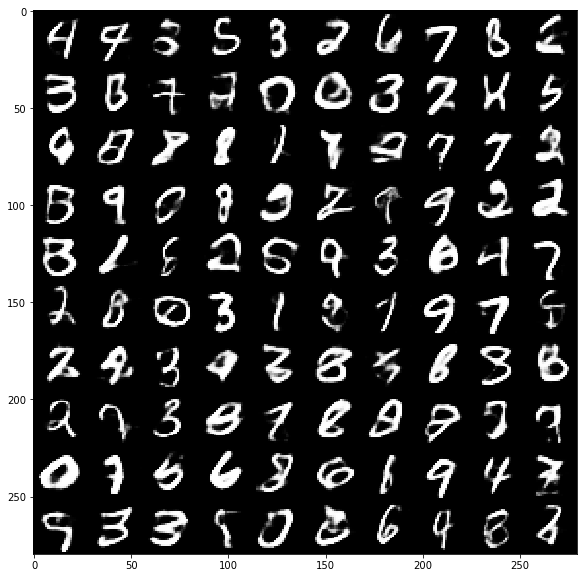

In [14]:
import matplotlib.pyplot as plt
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for j in range(n):
    for i in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[:, :, 0]
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# IAF VAE

In [15]:
# Encoder
enc_filters=32
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
    create_dense_layers(stage=5, width=intermediate_dim),
]
x_input = Input(batch_shape=(batch_size,) + original_img_size)
_enc_dense = inst_layers(enc_layers, x_input)

# Original z_0
e_0 = Lambda(epsilon)(_enc_dense)
_z_sigmas = []
_z_mean_0 = Dense(latent_dim)(_enc_dense)
_z_log_sigma_0 = Dense(latent_dim)(_enc_dense)
z_0 = Lambda(combine_z_0)([e_0, _z_mean_0, _z_log_sigma_0])

# IAF flows
masking_dim = 10 * latent_dim
h = Dense(latent_dim, activation='sigmoid')(_enc_dense)
z_t = z_0
for i in range(num_iaf):
    reverse = (i > 0)
    z_t, _z_sigma_t = make_iaf_layer(z_t, h, reverse=reverse)
    _z_sigmas.append(_z_sigma_t)
z = z_t

# Decoder
dec_filters = 32
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    create_dense_layers(stage=11, width=14 * 14 * 64),
    Reshape((14, 14, 64)),
    create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(14, filters=dec_filters, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=1, kernel_size=1, strides=1, activation='sigmoid'),
]
_dec_dense = inst_layers(decoder_layers, z)
_output = _dec_dense

In [16]:
vae = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (100, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
enc_conv_1 (Conv2D)              (100, 28, 28, 32)     320         input_3[0][0]                    
____________________________________________________________________________________________________
activation_11 (Activation)       (100, 28, 28, 32)     0           enc_conv_1[0][0]                 
____________________________________________________________________________________________________
enc_conv_2 (Conv2D)              (100, 28, 28, 32)     9248        activation_11[0][0]              
___________________________________________________________________________________________

In [17]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=25 + 5 * num_iaf)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.001 * learning_rate)

callbacks=[early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  4351.880874633789


,loss,lr,val_loss
count,167.000000,167.000000,167.000000
mean,72.169146,0.000710,73.308049
std,7.986811,0.000368,4.383391
min,66.445564,0.000063,70.892102
0%,66.445564,0.000063,70.892102
25%,67.473534,0.000250,71.184998
50%,70.935936,0.001000,72.496783
75%,73.947677,0.001000,73.454008
95%,81.416599,0.001000,78.780353
99%,92.146826,0.001000,87.181030


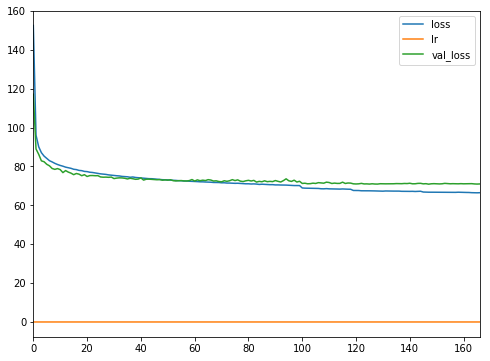

In [18]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [19]:
# Eval logpx loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpx_z)
val_logpx = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logpz loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpz)
val_logpz = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logqz_x loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logqz_x)
val_logqz_x = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

print()
print("log(p(x|z)) = %.2f" % val_logpx)
print("log(p(z)) = %.2f" % val_logpz)
print("log(q(z|x)) = %.2f" % val_logqz_x)

 9600/10000 [===========================>..] - ETA: 0s
log(p(x|z)) = 39.99
log(p(z)) = 45.16
log(q(z|x)) = 14.33


In [20]:
g_z = Input(shape=(latent_dim,))
g_output = inst_layers(decoder_layers, g_z)
generator = Model(g_z, g_output)

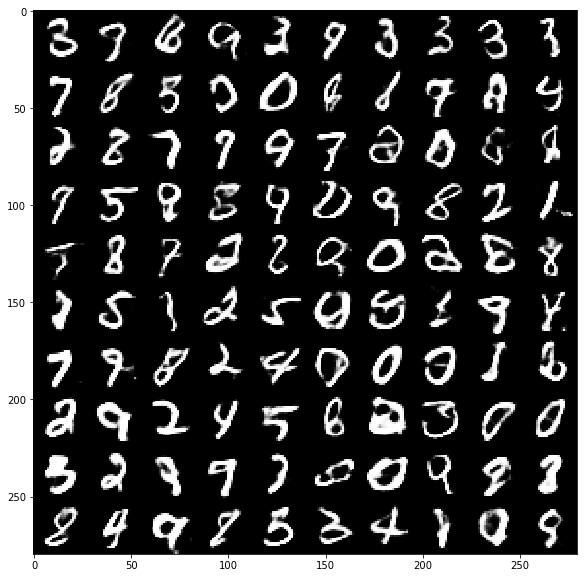

In [21]:
import matplotlib.pyplot as plt
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for j in range(n):
    for i in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[:, :, 0]
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()